In [ ]:
import jax
import numpy as np
import jax.numpy as jnp
import equinox as eqx
import optax

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.style as mplstyle

import seaborn as sns

In [ ]:
plt.style.use('default')
sns.set_theme(context='paper', style='white', palette='icefire', font='serif',
            font_scale=2, color_codes=True, rc={'text.usetex' : True})
mplstyle.use('fast')

In [ ]:
class Neuron(eqx.Module):
    weight: jax.Array
    bias: jax.Array
    activation: callable

    def __init__(self, in_features, activation=jax.nn.relu, key=None):
        if key is None:
            key = jax.random.PRNGKey(0)
            key, _ = jax.random.split(key)
        w_key, b_key = jax.random.split(key)
        self.weight = jax.random.normal(w_key, (in_features,))
        self.bias = jax.random.normal(b_key, ())

        self.activation = activation

    def __call__(self, x):
        return self.activation(jnp.dot(self.weight, x) + self.bias)


In [ ]:
def identity(x):
    return x


In [ ]:
class CustomMLP(eqx.Module):
    layers: list

    def __init__(self, input_size, hidden_sizes, output_size, key=None):
        if key is None:
            key = jax.random.PRNGKey(0)
        keys = jax.random.split(key, len(hidden_sizes) + 1)

        layers = []
        in_features = input_size

        # Create hidden layers
        for i, out_features in enumerate(hidden_sizes):
            layer = [Neuron(in_features, jax.nn.relu, key=keys[i]) for _ in range(out_features)]
            layers.append(layer)
            in_features = out_features

        # Create output layer
        output_layer = [Neuron(in_features, activation=identity, key=keys[-1]) for _ in range(output_size)]
        layers.append(output_layer)

        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = jnp.array([neuron(x) for neuron in layer])
        return x[0]  # Since output layer is a single neuron

    def add_neuron(self, layer_index, activation=jax.nn.relu, key=None):
        if key is None:
            key = jax.random.PRNGKey(0)
        in_features = self.layers[layer_index][0].weight.shape[0]
        new_neuron = Neuron(in_features, activation, key)
        self.layers[layer_index].append(new_neuron)

        # Adjust the next layer's weight matrix to include the new neuron
        if layer_index + 1 < len(self.layers):
            for i, next_neuron in enumerate(self.layers[layer_index + 1]):
                new_weight = jax.random.normal(key, (1,))
                updated_weights = jnp.append(next_neuron.weight, new_weight)
                self.layers[layer_index + 1][i] = eqx.tree_at(lambda n: n.weight, next_neuron, updated_weights)

    def remove_neuron(self, layer_index, neuron_index):
        if len(self.layers[layer_index]) > 0:
            del self.layers[layer_index][neuron_index]
        
        # Adjust the next layer's weight matrix to remove the corresponding weight
        if layer_index + 1 < len(self.layers):
            for i, next_neuron in enumerate(self.layers[layer_index + 1]):
                updated_weights = jnp.delete(next_neuron.weight, neuron_index)
                self.layers[layer_index + 1][i] = eqx.tree_at(lambda n: n.weight, next_neuron, updated_weights)
    
    def get_shape(self):
        return [len(layer) for layer in self.layers]


In [ ]:
def initialize_optimizer_state(mlp, optimizer):
    return optimizer.init(eqx.filter(mlp, eqx.is_inexact_array))


In [ ]:

input_size = 3
hidden_sizes = [4, 5]  # Two hidden layers with 4 and 5 neurons respectively
output_size = 1

key = jax.random.PRNGKey(42)
mlp = CustomMLP(input_size, hidden_sizes, output_size, key)
opt = optax.adam(learning_rate=1e-2)
opt_state = initialize_optimizer_state(mlp, opt)


In [ ]:
mlp.get_shape()

[4, 5, 1]

In [ ]:
x = jnp.array([1.0, 2.0, 3.0])
y = jnp.array([1.0])

In [ ]:
@eqx.filter_value_and_grad()
def compute_loss(mlp, x, y):
    pred = mlp(x)
    return jnp.mean((pred - y) ** 2)

In [ ]:
@eqx.filter_jit()
def train_step(mlp, x, y, opt_state, opt_update):
    loss, grads = compute_loss(mlp, x, y)
    updates, opt_state = opt_update(grads, opt_state)
    mlp = eqx.apply_updates(mlp, updates)
    return loss, mlp, opt_state

In [ ]:
mlp = CustomMLP(input_size, hidden_sizes, output_size, key)

In [ ]:
activation_list = [jax.nn.relu, jax.nn.sigmoid, jax.nn.tanh]
jax.random.choice(key, jnp.arange(len(activation_list)))

Array(2, dtype=int32)

In [ ]:
activation_list = [jax.nn.relu, jax.nn.sigmoid, jax.nn.tanh]
num_epochs = 100
add_node_every = 1
remove_node_every = 1
Loss_history = []
Node_history = []

In [ ]:
len(mlp.layers[0])

4

In [ ]:
for epoch in range(num_epochs):
    loss, mlp, opt_state = train_step(mlp, x, y, opt_state, opt.update)
    key, add_key, sub_key = jax.random.split(key,3)
    n_neurons = sum(mlp.get_shape())
    Loss_history.append(loss)
    Node_history.append(n_neurons)

    # Dynamically add or remove neurons
    if (epoch + 1) % add_node_every == 0 and jax.random.uniform(add_key) < 0.05:
        add_key, act_key = jax.random.split(add_key)
        activation = activation_list[jax.random.choice(key, jnp.arange(len(activation_list)))]
        layers = len(mlp.get_shape()) - 1
        layer = jax.random.randint(act_key, (1,), 0, layers)[0]
        mlp.add_neuron(layer_index=1, activation=activation, key=add_key)
        opt_state = initialize_optimizer_state(mlp, opt)
        print(f"Added neuron to hidden layer {layer+1} with activation {activation.__name__}")
        print(mlp.get_shape())
    
    elif (epoch + 1) % remove_node_every == 0 and jax.random.uniform(sub_key) < 0.05:
        layer_key, neuron_key, sub_key = jax.random.split(sub_key,3)
        layers = len(mlp.get_shape()) - 1
        layer = jax.random.randint(layer_key, (1,), 0, layers)[0]
        layer_neurons = len(mlp.layers[layer])
        neuron_idx = jax.random.randint(neuron_key, (1,), 0, layer_neurons)[0]
        mlp.remove_neuron(layer_index=layer, neuron_index=neuron_idx)
        opt_state = initialize_optimizer_state(mlp, opt)
        print(f"Removed neuron from hidden layer {layer+1} at index {neuron_idx}")
        print(mlp.get_shape())

    print(f"Epoch {epoch}, Prediction: {mlp(x)}, Loss: {loss}")

print("Final Prediction:", mlp(x))

Epoch 0, Prediction: -0.11493870615959167, Loss: 1.2654868364334106
Epoch 1, Prediction: -0.1049412339925766, Loss: 1.2430883646011353
Epoch 2, Prediction: -0.09494777023792267, Loss: 1.2208951711654663
Epoch 3, Prediction: -0.08496008813381195, Loss: 1.1989107131958008
Epoch 4, Prediction: -0.07497978210449219, Loss: 1.1771384477615356
Epoch 5, Prediction: -0.0650084912776947, Loss: 1.1555814743041992
Epoch 6, Prediction: -0.055047959089279175, Loss: 1.134243130683899
Epoch 7, Prediction: -0.04509981349110603, Loss: 1.113126277923584
Epoch 8, Prediction: -0.035165734589099884, Loss: 1.092233657836914
Epoch 9, Prediction: -0.02524735778570175, Loss: 1.071568250656128
Epoch 10, Prediction: -0.01534633245319128, Loss: 1.051132082939148
Epoch 11, Prediction: -0.005464295856654644, Loss: 1.030928134918213
Epoch 12, Prediction: 0.00439715851098299, Loss: 1.0109584331512451
Epoch 13, Prediction: 0.01423643808811903, Loss: 0.991225004196167
Epoch 14, Prediction: 0.02405199408531189, Loss: 0.9

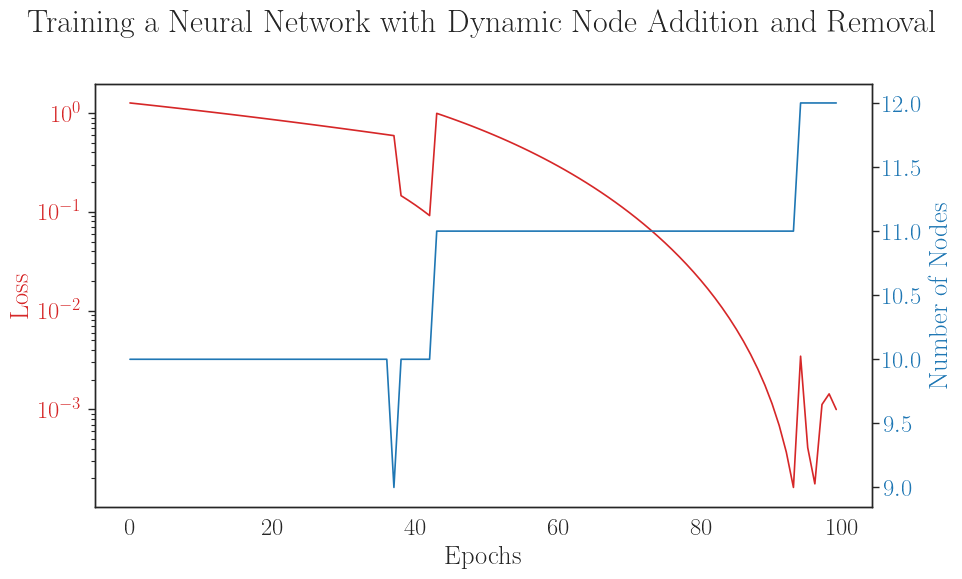

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(np.arange(0,num_epochs), Loss_history, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale("log")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Number of Nodes', color=color)  # we already handled the x-label with ax1
ax2.plot(np.arange(0,num_epochs), Node_history, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.suptitle("Training a Neural Network with Dynamic Node Addition and Removal")
fig.tight_layout()